# Prospective Attention

#### Todo: 

1. Scale the time by the context length

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import multivariate_normal
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# functions
# def sample_from_task_sequence(t, N=10):
#     if (t // (N/2)) % 2 == 0:
#         mu = 1
#     else:
#         mu = -1
#     Y = np.random.binomial(1, 0.5)
#     X = np.random.normal((-1)**(Y+1)*mu, 0.5)
#     return X, t, Y

def sample_from_task_sequence(t, N=10):
    Y = np.random.binomial(1, 0.5)
    L = Y
    if (t // (N/2)) % 2 != 0:
        L = 1 - Y
    X = L * np.random.uniform(-2, -1) + (1-L) * np.random.uniform(1, 2)
    return X, t, Y

def compute_cumulative_error(model, t, N, T, num_reps=10):
    preds = []
    gts = []
    model.eval()
    for rep in range(num_reps):
        testdata = np.array([sample_from_task_sequence(s, N) for s in range(t, T)])
        Xt = torch.Tensor(testdata[:, :-1])
        Yt = testdata[:, -1]
        out = model(Xt)
        preds.append(out.detach().argmax(1).numpy())
        gts.append(Yt)
    preds = np.array(preds)
    gts = np.array(gts)
    mean_error = np.mean(preds != gts)
    std_error = np.std(preds != gts)
    return mean_error, std_error

In [126]:
# archiectures 
class AttentionLayer(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, p=0.1):
        super().__init__()
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, hidden_dim, p),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model, p),
        )
        self.mha = nn.MultiheadAttention(d_model, num_heads, p)
        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

    def forward(self, x):
        attn_output, _ = self.mha(x, x, x)
        out1 = self.layernorm1(x + attn_output)
        ff_output = self.feed_forward(out1)
        out2 = self.layernorm2(out1 + ff_output)
        return out2

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, d_model, num_heads, ff_hidden_dim, num_attn_blocks=1, num_classes=2, 
                 contextlength=200, C=100.0, max_len=5000):
        super().__init__()
        self.input_size = input_size
        self.d_model = d_model
        self.attention_blocks = nn.ModuleList(
            [AttentionLayer(d_model, num_heads, ff_hidden_dim) for _ in range(num_attn_blocks)]
        )
        self.input_embedding = nn.Linear(input_size+1, d_model//2)
        self.layernorm = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.classifier = nn.Linear(d_model, num_classes)

        # original sinusoidal encoding
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model//2, 2) * (-math.log(C) / (d_model//2)))
        pe = torch.zeros(1, max_len, d_model//2)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

        # modulo encoding
        position = torch.arange(max_len).unsqueeze(1)
        L = torch.arange(1, d_model//2+1, 1) * 5
        me = torch.fmod(position, L).unsqueeze(0) / L
        self.register_buffer('me', me)

        # randomized encoding
        position = torch.arange(max_len).unsqueeze(1)
        w = torch.normal(0, 1, (1, d_model//2))
        b = math.pi * torch.rand(1, d_model//2)
        re = torch.cos(position * w + b).unsqueeze(0) * math.sqrt(2/(d_model//2))
        self.register_buffer('re', re)

        # frequency-adjusted fourier encoding
        position = torch.arange(max_len).unsqueeze(1)
        div_term = 2 * math.pi / torch.arange(2, d_model//2 + 1, 2)
        ffe = torch.zeros(1, max_len, d_model//2)
        ffe[0, :, 0::2] = torch.sin(position * div_term)
        ffe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('ffe', ffe)
        

    def sinusoid_encoder(self, t):
        pos_enc = torch.cat([self.pe.cpu()[:, t[i].cpu().squeeze().long(), :] for i in range(t.size(0))])
        return pos_enc.to(device)

    def modulo_encoder(self, t):
        mod_enc = torch.cat([self.me[:, t[i].squeeze().long(), :] for i in range(t.size(0))])
        return mod_enc
    
    def randomized_encoder(self, t):
        rand_enc = torch.cat([self.re[:, t[i].squeeze().long(), :] for i in range(t.size(0))])
        return rand_enc
    
    def test_encoder(self, t):
        enc = torch.cat([self.ffe[:, t[i].squeeze().long(), :] for i in range(t.size(0))])
        return enc
        
    def forward(self, z):
        x, t, y = torch.split(z, [self.input_size, 1, 1], dim=-1)
        u = torch.cat((x, y), dim=-1)
        u = self.input_embedding(u)

        # type of temporal encoder
        # t = self.sinusoid_encoder(t)
        # t = self.modulo_encoder(t)
        # t = self.randomized_encoder(t)
        t = self.test_encoder(t)

        # type of aggregation
        # x = self.layernorm(u + t)
        x = torch.cat((u, t), dim=-1)

        for attn_block in self.attention_blocks:
            x = attn_block(x)
        x = torch.select(x, 1, -1)
        x = self.classifier(x)
        return x

# dataset 
class SequentialDataset(Dataset):
    def __init__(self, N, t, contextlength=200, seed=1996):
        np.random.seed(seed)
        data = np.array([sample_from_task_sequence(s, N) for s in range(0, t)])
        self.data = torch.from_numpy(data)
        self.contextlength = contextlength
        self.t = t

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        r = np.random.randint(0, len(self.data)-2*self.contextlength) # select the end of the subsequence
        s = np.random.randint(r+self.contextlength, r+2*self.contextlength)  # select a 'future' time beyond the subsequence
        z = torch.cat((self.data[r:r+self.contextlength], self.data[s:s+1]))
        y = z[-1, -1].clone()
        z[-1, -1] = 0.5
        return z, y

In [127]:
# distribution params
t = 1000 # length of the training sequence
N = 20   # period of switching tasks (task switches every N/2 time steps)

# training params
batch_size = 64
num_epochs = 50
lr = 0.01
contextlength = 200
verbose=True

# evaluation params
T = t + contextlength # future time horizon
num_reps = 10

In [129]:
dataset = SequentialDataset(N=N, t=t, contextlength=contextlength)
trainloader = DataLoader(dataset, batch_size=batch_size)
nb_batches = len(trainloader)

model = TransformerClassifier(
    input_size=1,
    d_model=256, 
    num_heads=4,
    ff_hidden_dim=1024,
    num_attn_blocks=1,
    num_classes=2, 
    contextlength=contextlength,
    C=100
)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    losses = 0.0
    train_acc = 0.0
    for z, y in trainloader:
        z = z.float().to(device)
        y = y.long().to(device)

        out = model(z)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        losses += loss.item()
        optimizer.step()
        train_acc += (F.softmax(out, dim=1).argmax(1) == y).detach().cpu().numpy().mean()
    scheduler.step()
    if verbose and epoch % 10 == 0:
        print("Training loss at epoch {} : {:4f}, Training Acc : {:4f}".format(epoch+1, losses/nb_batches, train_acc/nb_batches))

Training loss at epoch 1 : 0.172823, Training Acc : 0.935547
Training loss at epoch 11 : 0.003344, Training Acc : 1.000000
Training loss at epoch 21 : 0.001776, Training Acc : 1.000000
Training loss at epoch 31 : 0.001230, Training Acc : 1.000000
Training loss at epoch 41 : 0.000857, Training Acc : 1.000000
Training loss at epoch 51 : 0.000668, Training Acc : 1.000000
Training loss at epoch 61 : 0.000618, Training Acc : 1.000000
Training loss at epoch 71 : 0.000466, Training Acc : 1.000000
Training loss at epoch 81 : 0.000408, Training Acc : 1.000000
Training loss at epoch 91 : 0.000388, Training Acc : 1.000000
Training loss at epoch 101 : 0.000350, Training Acc : 1.000000
Training loss at epoch 111 : 0.000305, Training Acc : 1.000000
Training loss at epoch 121 : 0.000278, Training Acc : 1.000000
Training loss at epoch 131 : 0.000269, Training Acc : 1.000000
Training loss at epoch 141 : 0.000238, Training Acc : 1.000000
Training loss at epoch 151 : 0.000219, Training Acc : 1.000000
Tra

In [130]:
class TestDataset(Dataset):
    def __init__(self, testdata, dataset, contextlength=200):
        self.testdata = torch.from_numpy(testdata)
        self.traindata = dataset.data
        # self.traindata = torch.from_numpy(dataset)
        self.contextlength = contextlength

    def __len__(self):
        return len(self.testdata)

    def __getitem__(self, idx):
        z = torch.cat((self.traindata[-contextlength:], self.testdata[idx:idx+1]))
        y = z[-1, -1].clone()
        z[-1, -1] = 0.5
        return z, y

num_reps = 100
T = t + 500
preds = []
truths = []
model.eval()
for rep in range(num_reps):
    np.random.seed(3000 + 1000 * rep)
    testdata = np.array([sample_from_task_sequence(s, N) for s in range(t, T)])
    # contextdata = np.array([sample_from_task_sequence(s, N) for s in range(t-contextlength, t)])
    testdataset = TestDataset(testdata, dataset)
    # testdataset = TestDataset(testdata, contextdata)
    testloader = DataLoader(testdataset, batch_size=100, shuffle=False)
    
    pred_rep = []
    truth_rep = []
    times = []

    for z, y in testloader:
        z = z.float().to(device)
        y = y.long().to(device)
        out = model(z)
        pred_rep.extend(out.detach().cpu().argmax(1).numpy())
        truth_rep.extend(y.detach().cpu().numpy())

    preds.append(pred_rep)
    truths.append(truth_rep)
preds = np.array(preds)
truths = np.array(truths)

In [131]:
mean_error = np.mean(preds != truths, axis=0).squeeze()
std_error = np.std(preds != truths, axis=0).squeeze()
ci = std_error * 1.96/np.sqrt(num_reps).squeeze()

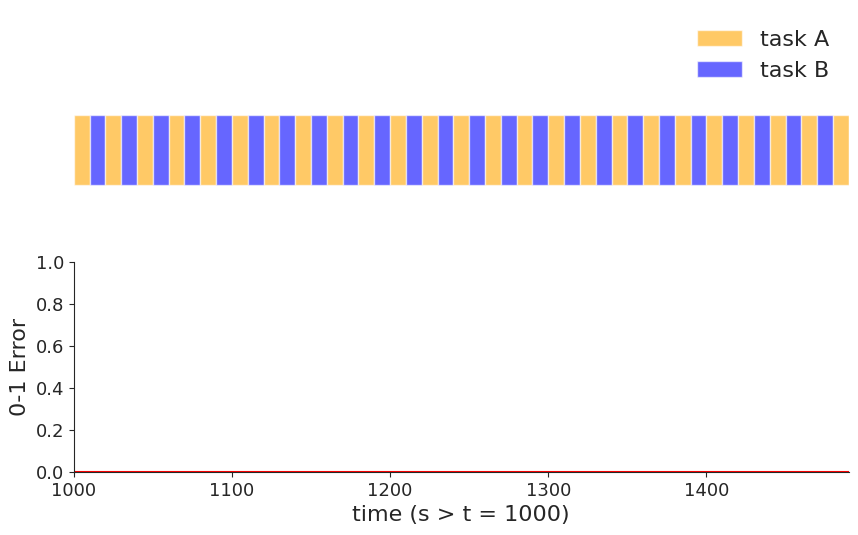

In [132]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
ax = axes[0]
future = np.arange(t, T, 1)
xlocs = np.arange(t, T, N/2)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes[1]
ax.plot(future, mean_error, c='r')
ax.fill_between(future, mean_error-ci, mean_error+ci, alpha=0.2, color='r')
ax.set_ylabel("0-1 Error", fontsize=16)
ax.set_xlabel("time (s > t = {})".format(t), fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.set_ylim([0, 1])
plt.show()

### Plot the Q, K, V matrices

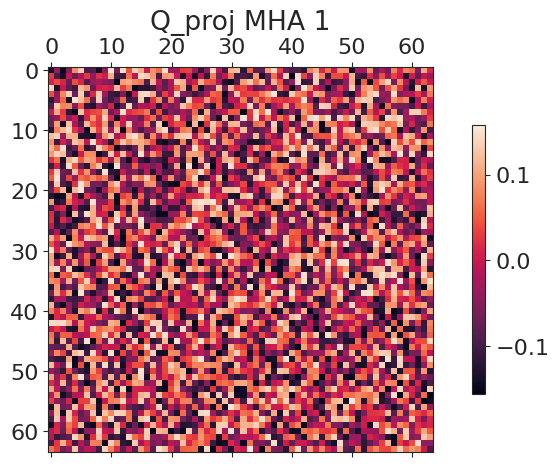

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(1):
    qkv = model.attention_blocks[i].mha.in_proj_weight
    qkv = qkv.detach().cpu().numpy()
    dmodel = qkv.shape[1]
    cax = ax.matshow(qkv[:dmodel, :dmodel].T)
    ax.set_title(f"Q_proj MHA {i+1}")
    fig.colorbar(cax, ax = ax, shrink=0.7)

### Plot the Positional Encoder Responses

In [9]:
model = TransformerClassifier(
    input_size=1,
    d_model=256, 
    num_heads=4,
    ff_hidden_dim=1024,
    num_attn_blocks=1,
    num_classes=2, 
    contextlength=contextlength,
    C=100
)

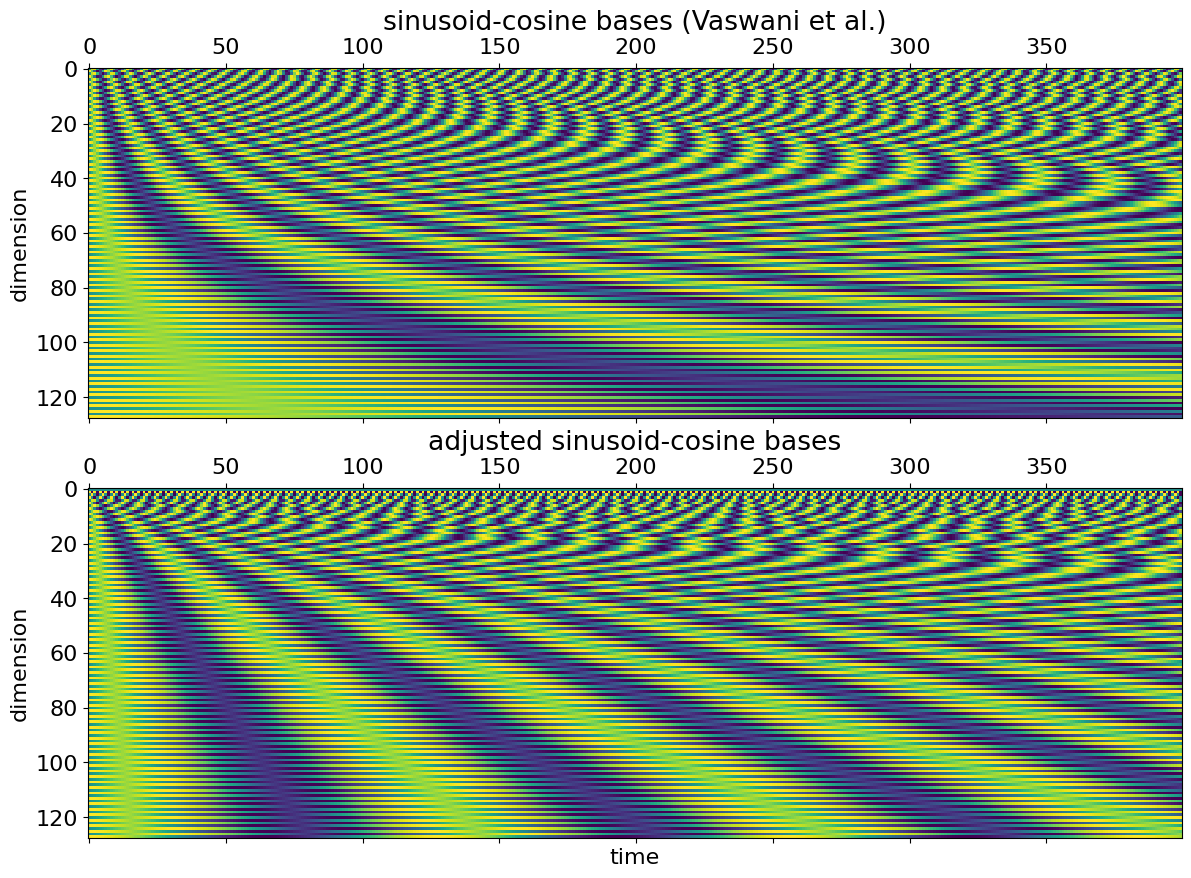

In [11]:
pe = model.pe.detach().cpu().numpy().squeeze()
me = model.ffe.detach().cpu().numpy().squeeze()

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].matshow(pe[:400].T)
ax[0].set_title("sinusoid-cosine bases (Vaswani et al.)")
ax[0].set_ylabel("dimension")
ax[1].matshow(me[:400].T)
ax[1].set_title("adjusted sinusoid-cosine bases")
ax[1].set_ylabel("dimension")
ax[1].set_xlabel("time")
plt.show()

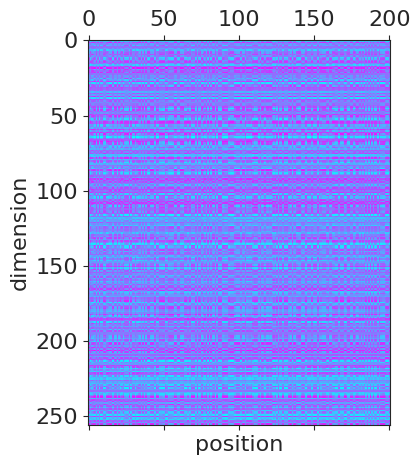

In [91]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(out[0][3].detach().cpu().T, cmap='cool')
ax.set_xlabel("position")
ax.set_ylabel("dimension")
plt.show()


### time vs. cumulative risk over the future plot

In [11]:
N = 10
t_list = [100, 500, 1000, 1500, 2000]
T = 5000
num_epochs = 6000
num_reps = 100

data = np.array([sample_from_task_sequence(s, N) for s in range(0, t_list[-1])])

In [ ]:
cumulative_error = []
std_cumulative_error = []
for t in t_list:
    print(t)
    data_t = data[:t]
    X = data_t[:, :-1]
    Y = data_t[:, -1]
    trainloader = get_dataloader(X, Y)
    model = net2(d=1, h=50, num_periods=20, num_hidden=3, num_classes=2)
    model.to(device)
    model = train(model, trainloader, num_epochs, verbose=False)
    mean_err, std_err = compute_cumulative_error(model, t, N, T, num_reps)
    cumulative_error.append(mean_err)
    std_cumulative_error.append(std_err)
cumulative_error = np.array(cumulative_error)
std_cumulative_error = np.array(std_cumulative_error)
ci = std_cumulative_error * 1.96 / np.sqrt(num_reps)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(t_list, cumulative_error, 'o-')
ax.fill_between(t_list, cumulative_error-ci, cumulative_error+ci, alpha=0.2)
ax.set_xlabel('t')
ax.set_ylabel(r'cumulative risk until $T = {}$'.format(T))
plt.show()

### Autocorrelation plot

In [5]:
data = np.array([sample_from_task_sequence(t, N=20) for t in range(200)])
x, y, t = data[:, 0], data[:, -1], data[:, 1]

In [6]:
import pandas as pd

In [7]:
k_list = np.arange(1, 50+1, 1)
r_k = []
z = x * y
s = pd.Series(z)
for k in k_list:
    # r_xx = 1/(len(data)-k) * np.sum(z[:-k] * z[k:])
    r_xx = s.autocorr(lag=k)
    r_k.append(r_xx)

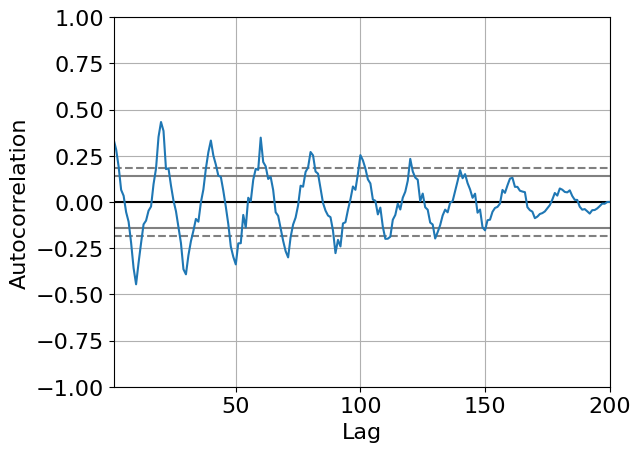

In [8]:
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(z)
 
# plotting the Curve
x.plot()
 
# Display
plt.show()

In [9]:
from scipy.signal import periodogram

In [11]:
f, Pxx_den = periodogram(z, fs=1)

Text(0, 0.5, 'PSD')

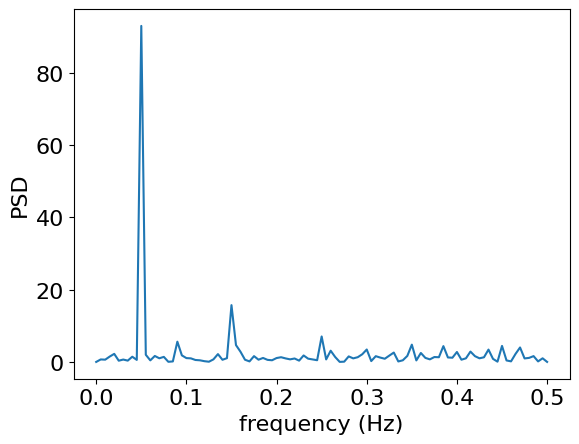

In [16]:
plt.plot(f, Pxx_den)
plt.xlabel("frequency (Hz)")
plt.ylabel("PSD")

### DEV

In [23]:
x = np.random.normal(0, 1, size=(1000))
x.sort()

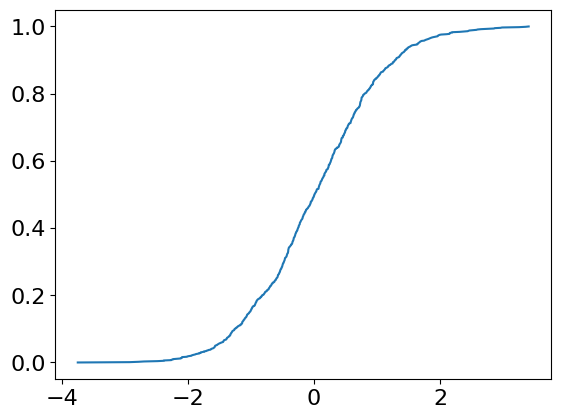

In [24]:
plt.plot(x, np.linspace(0, 1, len(x)))

In [13]:
C = 10000
omega1 = 1 / (C**(2*np.arange(1, 100, 1)/100))
omega2 = 2 * np.pi / np.arange(1, 100, 1)

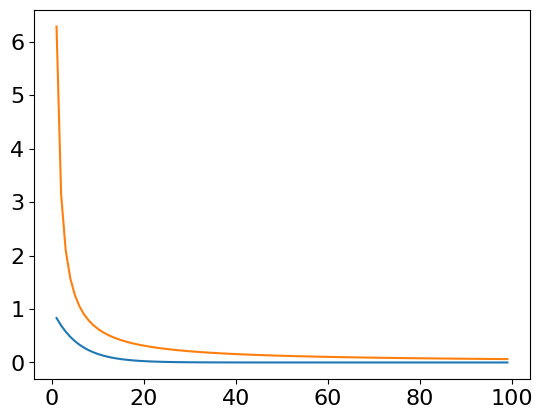

In [14]:
plt.plot(np.arange(1, 100, 1), omega1)
plt.plot(np.arange(1, 100, 1), omega2)

In [23]:
d_model = 128
div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

In [27]:
div_term

tensor([1.0000e+00, 8.6596e-01, 7.4989e-01, 6.4938e-01, 5.6234e-01, 4.8697e-01,
        4.2170e-01, 3.6517e-01, 3.1623e-01, 2.7384e-01, 2.3714e-01, 2.0535e-01,
        1.7783e-01, 1.5399e-01, 1.3335e-01, 1.1548e-01, 1.0000e-01, 8.6596e-02,
        7.4989e-02, 6.4938e-02, 5.6234e-02, 4.8697e-02, 4.2170e-02, 3.6517e-02,
        3.1623e-02, 2.7384e-02, 2.3714e-02, 2.0535e-02, 1.7783e-02, 1.5399e-02,
        1.3335e-02, 1.1548e-02, 1.0000e-02, 8.6596e-03, 7.4989e-03, 6.4938e-03,
        5.6234e-03, 4.8697e-03, 4.2170e-03, 3.6517e-03, 3.1623e-03, 2.7384e-03,
        2.3714e-03, 2.0535e-03, 1.7783e-03, 1.5399e-03, 1.3335e-03, 1.1548e-03,
        1.0000e-03, 8.6596e-04, 7.4989e-04, 6.4938e-04, 5.6234e-04, 4.8697e-04,
        4.2170e-04, 3.6517e-04, 3.1623e-04, 2.7384e-04, 2.3714e-04, 2.0535e-04,
        1.7783e-04, 1.5399e-04, 1.3335e-04, 1.1548e-04])

In [28]:
1.1548e-04

0.00011548